## MED - Model regresji
## Bike Sharing 
Cześć druga


Autor: Andrzej Czechowski

## Hipoteza

Na podstawie warunków pogodowych oraz daty można przewidzieć ilość wypożyczonych rowerów.

Importy, tensorflow powinnen być wersji 2.7

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2.7.0


Wykresy, potrzebne do wizualizacji wyników.

In [190]:
def plot_prediction(test_predictions, test_labels, date, color_pred = 'C0'):
    # data1 = data[['dteday', 'cnt']]
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(date, test_predictions,label='prediction', color = color_pred)
    ax.plot(date, test_labels,label = 'true data',color = 'orange' )
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title('Wypożyczenia w danych dniach testowych')
    plt.legend()
    plt.show()

def plot_predictions(test_predictions, test_labels, date, labels,colors = ['C0','C2','C3','C4']):
    # data1 = data[['dteday', 'cnt']]
    fig, ax = plt.subplots(figsize=(20, 5))

    for test_prediction, label,color in zip(test_predictions,labels,colors):
        ax.plot(date, test_prediction,label='predict '+label,color = color)
    
    ax.plot(date, test_labels,label = 'true data',color = 'orange')
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title('Wypożyczenia w danych dniach testowych')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [cnt]')
    plt.legend()
    plt.grid(True)
    plt.show()

Tworzenie funkcji, do obliczenia współczynnik zbieżności R^2 oraz mediane błedu, aby oceniac modele.

In [191]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  median_error = np.median(abs(y - y_pred))
  return float(r2), float(median_error) 

Wczytanie danych, opracowanych w pierwsze czesci projektu. 

In [192]:
def wind(row):
    if row['windspeed'] > 0:
        return 1
    elif row['windspeed'] == 0:
        return 0

def prepared_data():
    data_hour = pd.read_csv('data/day.csv')
    data = data_hour
    data['dteday'] = pd.to_datetime(data['dteday'])
    data = data.drop('instant', axis=1)
    data = data.drop(columns=['temp'])
    data["is_wind"] = data.apply(lambda row: wind(row), axis=1)
    data = data.drop('casual',axis=1)
    data= data.drop('registered',axis=1)
    data['weathersit']= (data['weathersit']- data['weathersit'].min())/( data['weathersit'].max()- data['weathersit'].min()) 
    data['weathersit']= (data['yr']- data['yr'].min())/( data['yr'].max()- data['yr'].min()) 
    cnt = data.pop('cnt')
    data.insert(data.shape[1], 'cnt', cnt)
    return data

In [195]:
data = prepared_data()
date = data['dteday']
data = data.drop('dteday', axis=1)

Podział zboru na testowy i traingowy. Ostatnie 20 % procent danych będzie to zbioru treningowy, dzięki czemu będzie można bardzo dobrze wizualizować predykcje.

In [196]:
train_size = int(data.shape[0] / 10 * 8) + 1  # 80 procent

train_dataset = data.iloc[:train_size]
train_date = date[:train_size]

test_dataset = data.iloc[train_size:]
date_test = date[train_size:]

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cnt')
test_labels = test_features.pop('cnt')

scores = {}
list_of_preditions = []
lablels = []

## Model regresji liniowej.

(0.5703268211824695, 684.9443268766572)


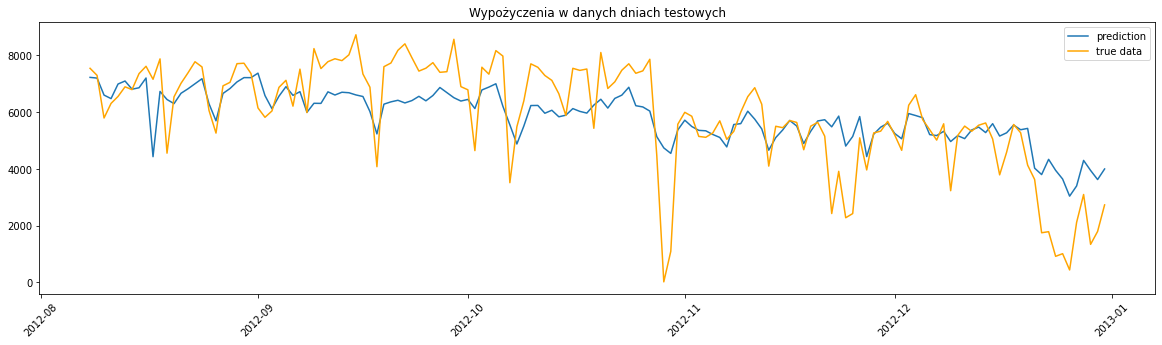

,feature,coef
0,atemp,5902.413095
1,windspeed,-2845.254926
2,hum,-2236.697201
3,weathersit,1005.689601
4,yr,1005.689601
5,holiday,-379.425299
6,season,265.992437
7,mnth,38.140854
8,workingday,38.082585
9,weekday,35.996394


In [197]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(train_features, train_labels)

model_LinearRegression.predict(train_features)
preditions = model_LinearRegression.predict(test_features)

score =  R_squared(test_labels,preditions) # return the same as model.score(test_feutures,test_labels)
print(score)

name_model = 'LinearRegression'
scores[name_model] = score 

list_of_preditions.append(preditions)
lablels.append(name_model)

# print(sorted(zip(train_features.columns,model_LinearRegression.coef_), key=lambda x: -abs(x[1])))

plot_prediction(preditions,test_labels,date_test)
pd.DataFrame(data = sorted(zip(train_features.columns,model_LinearRegression.coef_), key=lambda x: -abs((x[1]))), columns = ['feature','coef'])

Wnioski:
- Czynniki pogodowe w tym modelu mają największy wpływ.
- Model liniowy słabo działa, dla atrybutu określające datę (dzień tygodnia, miesiąc).
- Dodany przez nas cecha, czy  wieje ('is_wind', 0.0) nie ma żadnego znaczenia.

Ten sam model jednak podzielić atrybuty dzień tygodnia, miesiąc, sezon na osobne binarne kolumny.

In [143]:
def get_dummies_columns(data):
    data = pd.get_dummies(data, columns=['weekday'], prefix='weekday ', prefix_sep='')
    data = pd.get_dummies(data, columns=['mnth'], prefix='mnth ', prefix_sep='')
    data = pd.get_dummies(data, columns=['season'], prefix='season ', prefix_sep='')

    cnt = data.pop('cnt')
    data.insert(data.shape[1], 'cnt', cnt)
    return data

In [144]:
data_org = prepared_data()
data = data_org.copy()
data = get_dummies_columns(data)
date = data['dteday']
data = data.drop('dteday', axis=1)
data.iloc[:10,8:-1]

,weekday 0,weekday 1,weekday 2,weekday 3,weekday 4,weekday 5,weekday 6,mnth 1,mnth 2,mnth 3,...,mnth 7,mnth 8,mnth 9,mnth 10,mnth 11,mnth 12,season 1,season 2,season 3,season 4
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Ponowny podział zbioru, na zbiór treningowy i testowy.

In [145]:
train_size = int(data.shape[0] / 10 * 8) + 1  # 80 procent

train_dataset = data.iloc[:train_size]
train_date = date[:train_size]

test_dataset = data.iloc[train_size:]
date_test = date[train_size:]

train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('cnt')
test_labels = test_features.pop('cnt')

## Dobór cech

Zachłanny algorytm dobóru cech w przód. 

In [146]:
from sklearn.model_selection import cross_val_score
errors = []
the_best_score = 0

weekday = list(train_features.columns[8:15]) 
mnths  = list(train_features.columns[15:-4])
seazon = list(train_features.columns[-4:])

features = list(train_features.columns[:8].values)
features.extend([weekday,mnths,seazon])

the_best_feuteures = []
lr = LinearRegression()

for L in range(0, 1 + len(features)):  
    errors = [] 
    for value in features:

        if value in the_best_feuteures:
            continue
        elif type(value) == list:
            if value[0] in the_best_feuteures:
                continue

        tmp_the_best_feuteures = the_best_feuteures.copy()
        
        if type(value) == list:
            tmp_the_best_feuteures.extend(value) # dla weekday, mnths, seazon
        else:
            tmp_the_best_feuteures.append(value)
        
        error = np.mean(cross_val_score(lr,train_features[tmp_the_best_feuteures], train_labels))
        errors.append((tmp_the_best_feuteures, error))
       
    errors = [(k,v) for k, v in sorted(errors, key=lambda item: item[1])]
 
    if  errors[-1][1] <  the_best_score and the_best_score != 0: # Jesli  dodanie cechy zwieksza bład, to zakoncz algorytm  
        break

    the_best_feuteures = errors[-1][0]
    the_best_score = errors[-1][1]

print('the_best_feuteures\n',the_best_feuteures)
print('the_best_cross_value score\n',the_best_score)

the_best_feuteures
 ['season 1', 'season 2', 'season 3', 'season 4', 'weathersit', 'atemp', 'hum', 'windspeed', 'yr']
the_best_cross_value score
 0.13487758607588013


In [147]:
print('atributies not in the_best_feuteures')
print([x for x in train_features.columns.values if x not in the_best_feuteures])

atributies not in the_best_feuteures
['holiday', 'workingday', 'is_wind', 'weekday 0', 'weekday 1', 'weekday 2', 'weekday 3', 'weekday 4', 'weekday 5', 'weekday 6', 'mnth 1', 'mnth 2', 'mnth 3', 'mnth 4', 'mnth 5', 'mnth 6', 'mnth 7', 'mnth 8', 'mnth 9', 'mnth 10', 'mnth 11', 'mnth 12']


- Algorytm doboru cech w przód jest zachłanny, czyli dobrany przez zbiór cech nie oznacza, że jest najlepszy.
- Czynniki pogodowe oraz pora roku i rok  mają wpływ na końcowy wynik.
- W the_best_feuteures nie ma dnia tygodnia ani czy dzień jest pracujący, widocznie cechy te nie mają dużego wpływ na wynik.
- Również ten algorytm doboru cech, nie dobiera pojedynczych cech binarnych z sobą powiązanych (np. 'season 1'), tylko cały zestaw (np. ‘season 1’, ‘season 2’, ‘season 3’, ‘season 4’)


## Regularyzacja

In [148]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model_cv = RidgeCV(alphas=np.arange(0, 1, 0.1), cv=cv, scoring='neg_mean_absolute_error')
# fit model
model_cv.fit(train_features[the_best_feuteures], train_labels)

# summarize chosen configuration
print(f'alpha: {model_cv.alpha_:.01f}')

alpha: 0.1


 - Wyszło, że dla model Ridge najlepsze wyniki osiąga dla współczynnika regularyzacji L2 = 0.1.
- Regularyzacja, jest bardzo mała, wiec nie występuje problem przeuczenia się modelu.

## Ocena współczyników modelów

Model liniowy z regularyzacja l2

(0.5463624504483735, 703.1739624425184)


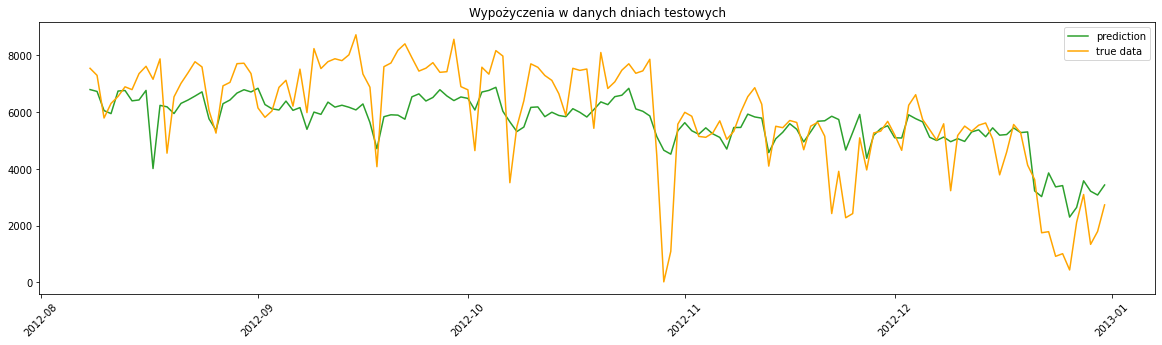

,feature,coef
0,atemp,5667.990839
1,windspeed,-3201.723813
2,hum,-2412.762841
3,yr,962.259044
4,weathersit,962.259044
5,season 1,-799.313633
6,season 4,580.124214
7,season 2,318.286601
8,season 3,-99.097182


In [187]:
model_Ridge = Ridge(alpha = 0.1)
model_Ridge.fit(train_features[the_best_feuteures], train_labels)

preditions = model_Ridge.predict(test_features[the_best_feuteures])

# score = model.score(test_features[the_best_feuteures],test_labels)
score =  R_squared(test_labels,preditions)
print(score)

name_model = 'Ridge_L2_01'
scores[name_model] = score

list_of_preditions.append(preditions)
lablels.append(name_model)

plot_prediction(preditions,test_labels,date_test,color_pred='C2')
pd.DataFrame(data = sorted(zip(train_features[the_best_feuteures].columns,model_Ridge.coef_), key=lambda x: -abs((x[1]))), columns = ['feature','coef'])

- Można zauważyć, spadek wypożyczeń w grudniu  wzrost na wiosnę.
- Waga atrybutu lato jest ujemna, jest to pewnie korekta na bardzo dobrą pogodę w występujące w wakacje.
- Atrybuty opisujące dobrą pogodę mają wagi dodatnie.
- Atrybuty opisujące złą pogodę (prędkość wiatru oraz wilgotność) mają wagi ujemne.

Model liniowy bez regularyzacji

(0.6038934676518657, 665.5)


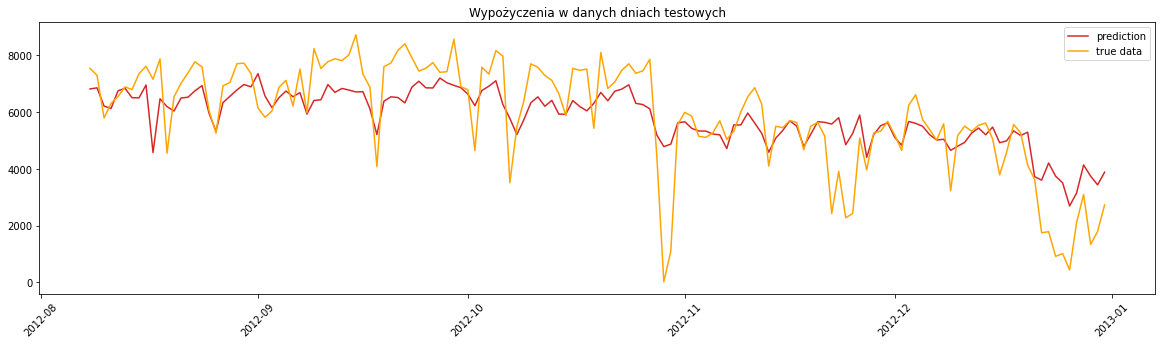

In [150]:
model_LinearRegression_all = LinearRegression()

model_LinearRegression_all.fit(train_features, train_labels)

model_LinearRegression_all.predict(train_features)
preditions = model_LinearRegression_all.predict(test_features)

score =  R_squared(test_labels,preditions)
print(score)

name_model = 'LinearRegression_with_binary_columns'
scores[name_model] = score

list_of_preditions.append(preditions)
lablels.append(name_model)

scores[name_model] = score

plot_prediction(preditions,test_labels,date_test,color_pred='C3')

Aby pokazać wpływ cech na wynik, posortowałem wagi.

In [151]:
features_with_coef =  sorted(zip(train_features.columns,model_LinearRegression_all.coef_), key=lambda x: abs((x[1])))
print(features_with_coef[:4],'\n')
print(features_with_coef[4:16],'\nthe biggest difference month', abs(features_with_coef[4][1] -features_with_coef[15][1]) )
print('\n')
print(features_with_coef[16:23],'\nthe biggest difference weekday', abs(features_with_coef[16][1] -features_with_coef[22][1]) )
print('\n')
print(features_with_coef[23:25] )
print('\n')
print(features_with_coef[25:29],'\nthe biggest difference sezon', abs(features_with_coef[25][1] -features_with_coef[28][1]) )
print('\n')
print(features_with_coef[29:])
pd.DataFrame(data = sorted(zip(train_features[the_best_feuteures].columns,model_Ridge.coef_), key=lambda x: -abs((x[1]))), columns = ['feature','coef'])

[('hum', -2646.2018868486584), ('windspeed', -3309.2110815658507), ('atemp', 4802.9898531545405), ('is_wind', 874700489088599.0)] 

[('mnth 1', 1064909583265829.6), ('mnth 2', 1064909583265969.1), ('mnth 12', 1064909583266459.0), ('mnth 3', 1064909583266470.0), ('mnth 7', 1064909583266477.5), ('mnth 11', 1064909583266513.0), ('mnth 4', 1064909583266556.5), ('mnth 8', 1064909583266764.5), ('mnth 6', 1064909583266843.0), ('mnth 10', 1064909583266863.0), ('mnth 5', 1064909583266995.0), ('mnth 9', 1064909583267121.0)] 
the biggest difference month 1291.375


[('weekday 1', 1645243881153498.5), ('weekday 3', 1645243881153511.2), ('weekday 2', 1645243881153581.0), ('weekday 4', 1645243881153601.2), ('weekday 5', 1645243881153638.0), ('weekday 6', -1757772169792238.2), ('weekday 0', -1757772169792459.8)] 
the biggest difference weekday 3403016050945958.0


[('workingday', -3403016050945873.0), ('holiday', -3403016050946208.0)]


[('season 4', -4645089267570160.0), ('season 2', -46450892675704

- Czynniki pogodowy weathersit, ma największy wpływ.

- Z wagi współczynnika year, można się spodziewać, że ilość wypożyczeń spada rok na rok (co jest nie prawdą), błąd ten wynika to z faktu, że dobrania zbioru trainigowego.

- Współczynniki sezon, są bardzo podobnej wielkości, wiec, mimo że te współczynniki mają duże wartości, to ma małe znaczenie dla wyniku.  

- Jeśli jest dzień pracujący, ilość wypożyczeń rośnie wiec współczynnik wagi  workingday powinnem być dodatatni, a tak nie jest. Przyczyną tego może być fakt, że większość dni niepracujących przypada, w sobotę i niedzielę a wagi tych atrybutów są ujemne.

- Współczynnik wagi dla wakacji jest ujemny, mimo że podczas wakacji jest wzrost wypożyczeń, wynikiem tego może być skorelowane z innymi atrybutami.

- Można zauważyć, że dla weekendu jest spadek wypożyczeń, wiec zamiast atrybutów dzień tygodnia, można zamienić na jedną cechę czy weekend.

- Wagi miesięcy, również mają wartości bardzo zbliżone, jednak różnica miedzy ich wartościami jest większa niż sezon, wiec mają one większy wpływ na wynik niż sezon.

- Zbiór traingowy jest źle dobrany, ponieważ sezonowość ma duże znaczenie, dlatego, aby dobrze prognozować ilość wypożyczeń na przyszły rok, należałoby wziąć losowy zbiór treningowy całych dwóch lat.

# Podsumowanie regresji liniowe 

In [152]:
scores

{'LinearRegression': (0.5703268211824695, 684.9443268766572),
 'Ridge_L2_01': (0.5463624504483735, 703.1739624425184),
 'LinearRegression_with_binary_columns': (0.6038934676518657, 665.5)}

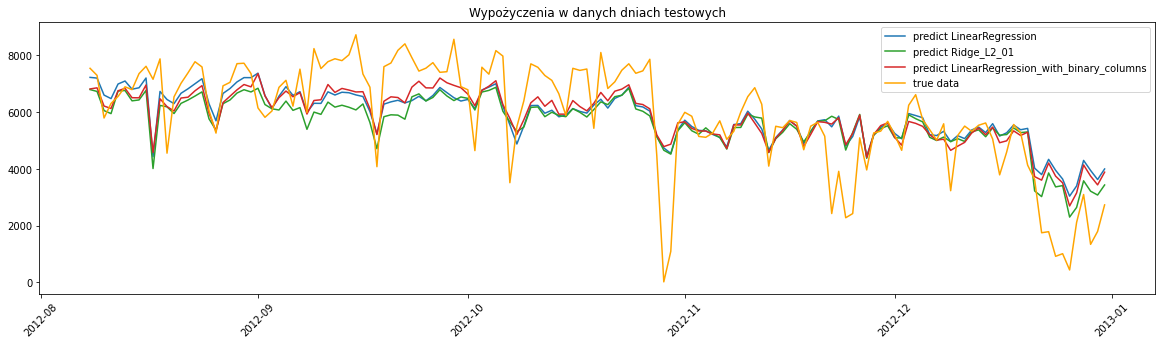

In [153]:
plot_predictions(list_of_preditions[:3],test_labels,date_test,lablels[:3])

- Wszystkich przypadkach regresja liniowa osiąga bardzo zbliżone wyniki.
- Dobór atrybutów, tworzenie atrybutów binarnych oraz dodanie regularyzacji nie poprawiło w predykcji.
- Modele dobrze, odczytuje czy w danym dniu będzie wzrost, czy spadek wartości.
- Modele słabo, radzą z dużym odchyleniem wartości a szczególnie dużym spadkami.
- Nie do szacowanie spadku, może wynikać z braku informacji o deszczu.
- Modele również słabo radzą sobie z dużymi wartości, przyczyną pewnie tego jest wystąpienie bardzo dobrej pogody.

## Regresja z wykorzystanie deep learnig 

Pierwszą warstwe normlizaltor.

In [154]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


Model DNN

In [155]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),

        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model


In [156]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 31)               63        
 ion)                                                            
                                                                 
 dense_40 (Dense)            (None, 64)                2048      
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 
 dense_43 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,496
Trainable params: 10,433
Non-trainable params: 63
________________________________________________

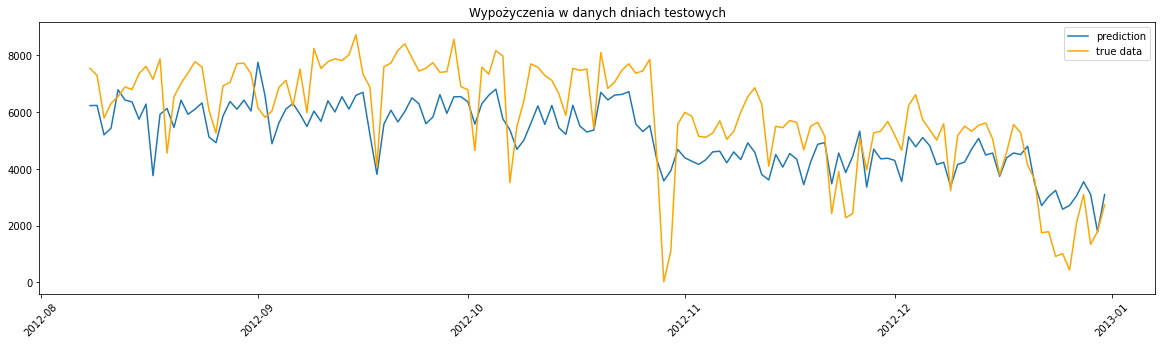

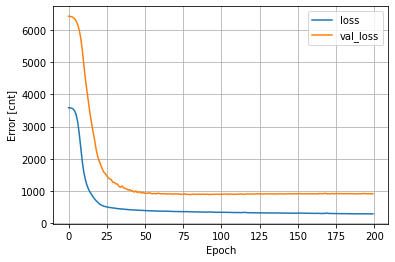

In [157]:

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200,
)


predictions = dnn_model.predict(test_features).flatten()

name_model = 'model_dnn'
scores[name_model]  = R_squared(test_labels,predictions)

list_of_preditions.append(predictions)
lablels.append(name_model)

plot_prediction(predictions,test_labels.values,date_test)
plot_loss(history)


Dodanie szumu gausowskiego aby zwiekszyć zbiór traingowy.

In [158]:
def adding_Gaussian_Noise_to_data(data, seed=2):
    np.random.seed(seed)
    columns = ['atemp', 'hum', 'windspeed']
    train_features_dsc = data.drop(columns, axis=1)
    gauss_noise_parameters = (1 - np.random.normal(0, 0.03, [data.shape[0], len(columns)]))
    gauss_noise_values = np.multiply(data[columns], gauss_noise_parameters)
    train_features_gaues_noise = pd.concat([train_features_dsc, gauss_noise_values], axis=1)
    train_features_gaues_noise = train_features_gaues_noise.append(train_features_dsc, ignore_index=True)

    return train_features_gaues_noise

In [159]:
train_features = adding_Gaussian_Noise_to_data(train_dataset, 2)

test_dataset = data.iloc[train_size:]

train_features = train_dataset.copy()
train_labels = train_features.pop('cnt')


Dnn model, dla danych traingowych zawierających szum gausowski

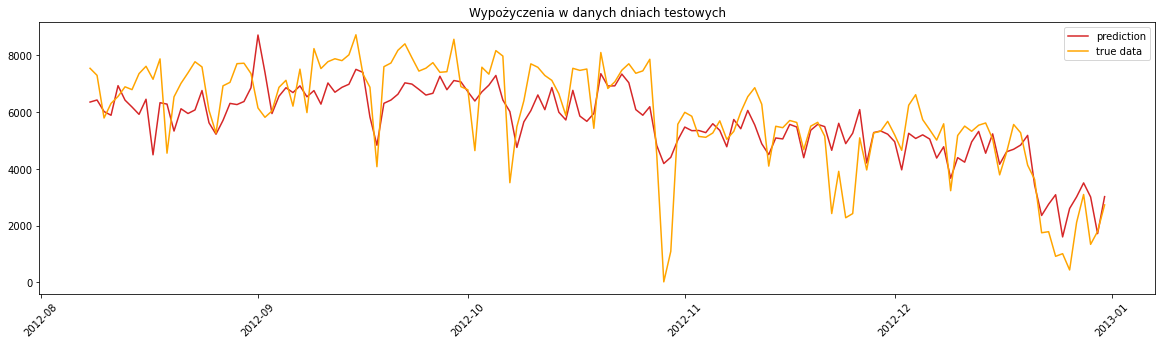

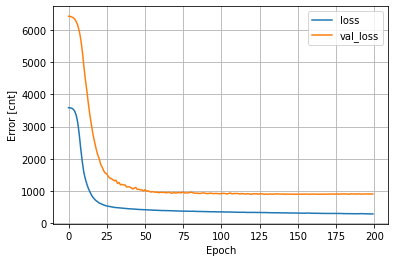

In [160]:
dnn_model_with_gausse_noise = build_and_compile_model(normalizer)

history = dnn_model_with_gausse_noise.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200,
)


predictions = dnn_model_with_gausse_noise.predict(test_features).flatten()

name_model = 'model_dnn_with_gausse_noise'
scores[name_model]  = R_squared(test_labels, predictions)

list_of_preditions.append(predictions)
lablels.append(name_model)

plot_prediction(predictions,test_labels.values,date_test,color_pred='C3')
plot_loss(history)


## Podsumowanie i ocena  modeli

 Współczynnik zbieżności R^2 oraz mediana błedu 

In [177]:
pd.DataFrame(data= [ [k, v[0], v[1]] for k,v in scores.items()], columns= ['model','R^2', 'median abs error'])

,model,R^2,median abs error
0,LinearRegression,0.570327,684.944327
1,Ridge_L2_01,0.546362,703.173962
2,LinearRegression_with_binary_columns,0.603893,665.500000
3,model_dnn,0.461350,1150.735840
4,model_dnn_with_gausse_noise,0.636348,734.011475


Modele regresji nie liniowej

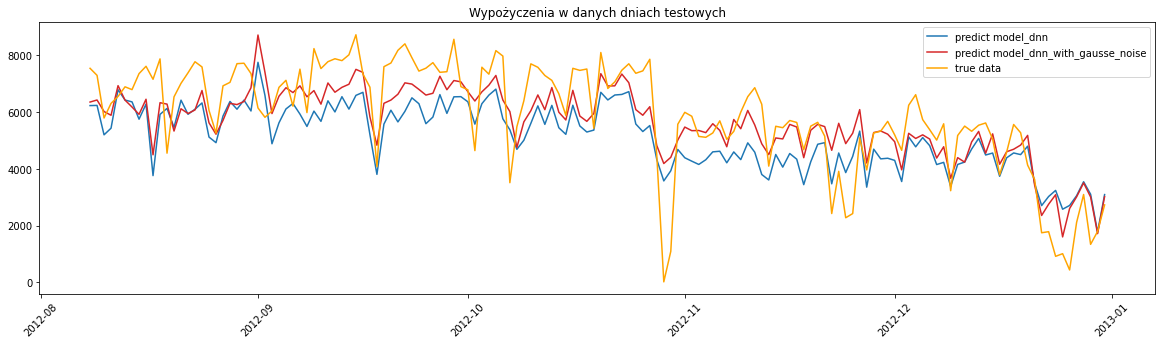

In [162]:
plot_predictions(list_of_preditions[3:],test_labels,date_test,lablels[3:],colors=['C0', 'C3'])

- Aby zwiększyć zbiór danych, dodałem szum gausowski, dzięki czemu model dnn lepiej się uczy.
- Mimo nie dużego zbioru danych, model regresji dnn z dodaniem szumu gausowskiego działa lepiej niż klasyczna regresja liniowa.
- Podczas testów, wyszło mi, że dodanie atrybutów binarnych, bardzo pomogło w regresji dnn.
- Predykacja modelu dnn, zależy bardzo od losowych wartości początkowych.
- Mediana błędu jest najmniejsza, dla regresji liniowej a to dlatego, że modele te bardziej uogólnieniają niż modele dnn. 